In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_ffnn, train, get_all_accuracy_rates, allocate_x_batch_ffnn, quantile_score, get_competition_preds


nn_type = 'ffnn'
allocate_x_batch = allocate_x_batch_ffnn
get_x_sequences = get_x_sequences_ffnn

In [2]:
np.random.seed(2021)

case=3
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 80


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([164958, 16])
torch.Size([118382, 1])
2016-01-01 20:00:00
2017-05-01 00:00:00
106327


In [3]:
input_size = x.shape[1] * pred_seq_len
hidden_size = 70
num_hidden = 5
out_size = 1
drop_p = 0

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        self.input_linear = nn.Linear(in_features=input_size,
                                      out_features=hidden_size,
                                      bias=True)
        self.output_linear = nn.Linear(in_features=hidden_size,
                                       out_features=out_size,
                                       bias=True)
        self.hidden_list = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_list.append(nn.Linear(in_features=hidden_size,
                                              out_features=hidden_size,
                                              bias=True))
        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        x = self.input_linear(x)
        x = self.dropout(x)
        x = self.act(x)
        for hidden_layer in self.hidden_list:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.act(x)
        x = self.output_linear(x)
        
        return x


net = Net()
print(net)


Net(
  (input_linear): Linear(in_features=1280, out_features=70, bias=True)
  (output_linear): Linear(in_features=70, out_features=1, bias=True)
  (hidden_list): ModuleList(
    (0): Linear(in_features=70, out_features=70, bias=True)
    (1): Linear(in_features=70, out_features=70, bias=True)
    (2): Linear(in_features=70, out_features=70, bias=True)
    (3): Linear(in_features=70, out_features=70, bias=True)
    (4): Linear(in_features=70, out_features=70, bias=True)
  )
  (act): ReLU()
  (dropout): Dropout(p=0)
)


In [4]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1000
num_epochs = 0
k_fold_size = 1

loss = nn.MSELoss()
#loss = nn.L1Loss()


optim_params = {'lr': 3e-3, 'weight_decay': 0}
train_loss, valid_loss, net = train(nn_type, x, y, Net, optim_params, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, case)
valid_loss[0] = np.sqrt(valid_loss[0])

#np.savez(outfile, train_loss=train_loss, valid_loss=valid_loss)

Fold 0: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 



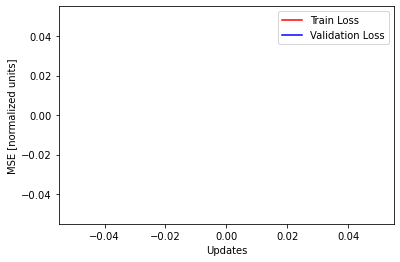

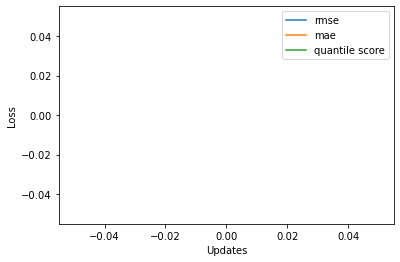

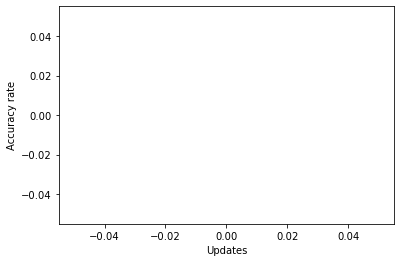

In [5]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss[:,:].mean(axis=-1), 'r', epoch, valid_loss[:,:,:].mean(axis=-1)[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()


plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:,:,:].mean(axis=-1)[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[:,:,:].mean(axis=-1)[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


In [6]:
with open(f'final_net/ffnn_--num_hidden_5_--hidden_size_70_--pred_seq_len_80_--loss_mse_--weight_decay_0.001_--dropout_0.1_--case_{case}.pkl', 'rb') as inp:
    net = pickle.load(inp)


In [7]:
split=10
predictions=np.zeros((0,1))
print(predictions.shape)
for i in range(split):
    idx = good_idx[i*len(good_idx)//split:(i+1)*len(good_idx)//split]
    
    x_batch = allocate_x_batch(len(idx), input_size, pred_seq_len)
    predictions = np.vstack((predictions,net(get_x_sequences(idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()))
    print(predictions.shape)
    

(0, 1)
(10632, 1)
(21265, 1)
(31898, 1)
(42530, 1)
(53163, 1)
(63796, 1)
(74428, 1)
(85061, 1)
(95694, 1)
(106327, 1)


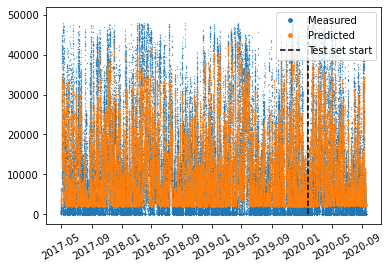

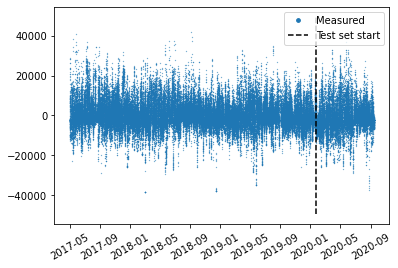

In [8]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
plt.plot((y_time[good_idx[-20000]],y_time[good_idx[-20000]]), (0, capacity(case)),'--',color='black',label='Test set start')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()


plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy()-capacity(case)*predictions, '.', markersize=0.5, label = 'Measured')
plt.plot((y_time[good_idx[-20000]],y_time[good_idx[-20000]]), (-capacity(case), capacity(case)),'--',color='black',label='Test set start')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [9]:
print('test accuracy:',accuracy_rate(torch.Tensor(predictions[-20000:]*capacity(case)), y[good_idx[-20000:]]*capacity(case), capacity(case)))
print('val/train accuracy:',accuracy_rate(torch.Tensor(predictions[:-20000]*capacity(case)), y[good_idx[:-20000]]*capacity(case), capacity(case)))



test accuracy: tensor(0.8674)
val/train accuracy: tensor(0.8721)


In [10]:
x_batch = allocate_x_batch(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences, good_idx, idx_offset, pred_seq_len, case)



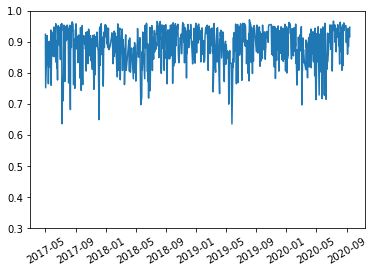

Mean accuracy rate 0.8908863


In [11]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))

In [12]:
day=3
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)

In [13]:
day=4
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)